In [79]:
# import lib 
import torch
import GPy
import numpy as np
import matplotlib.pyplot as plt
# import file
from FixedGP import FixedGP
from FixedOnlineGP import FixedOnlineGP, standardize_vector
import time

#### **Objective**: We want to measure how the inversion method with schur complement is faster than with cholesky and the complexity of this inversion. We will use the FixedOnlineGP class for GPs. 

#### Build the data 

In [80]:
nb_it = 5000

# Création de la grille de points dans l'hypercube normalisé (0, 1) x (0, 1)
x_coords = np.linspace(0, 1, 10)
y_coords = np.linspace(0, 1, 10)
X_test_normed = np.array(np.meshgrid(x_coords, y_coords)).T.reshape(-1, 2)

# Génération de train_X en prenant nb_it points aléatoires avec remise dans X_test_normed
train_X_indices = np.random.choice(X_test_normed.shape[0], nb_it, replace=True)
train_X = X_test_normed[train_X_indices]

# Génération de valeurs aléatoires standardisées pour train_Y
train_Y = np.random.randn(nb_it).reshape(-1,1)
train_Y = standardize_vector(train_Y)

#### Simulate the online GPs

In [ ]:
rep = 1

gp_dur = np.zeros((2, rep, nb_it))
inv_dur = np.zeros((2, rep, nb_it))

for r in range(rep):
    gp1 = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
    gp1.set_kernel()
    gp2 = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
    gp2.set_kernel()
    for i in range(nb_it):

        ## ----- 1st GP with Schur complement method ----- ##
        tic_gp1 = time.perf_counter()
        inv_dur1 = gp1.update(query_x = train_X[i], query_y = train_Y[i])
        tac_up1 = time.perf_counter()
        gp1.predict()
        tac_gp1 = time.perf_counter()

        ## ----- 2nd GP with Cholesky method ----- ##
        inv_dur2 = gp2.update_no_schur(query_x = train_X[i], query_y = train_Y[i])
        tac_up2 = time.perf_counter()
        gp2.predict()
        tac_gp2 = time.perf_counter()


        gp_dur[0,r,i] = tac_gp1 - tic_gp1
        gp_dur[1,r,i] = tac_gp2 - tac_gp1
        inv_dur[0,r,i] = inv_dur1
        inv_dur[1,r,i] = inv_dur2     

#### Post process

In [ ]:
gp1_duration = np.mean(gp_dur[0], axis= 0)
gp2_duration = np.mean(gp_dur[1], axis= 0)

# gp1_duration_std = np.std(gp_dur[0], axis= 0)
# gp2_duration_std = np.std(gp_dur[1], axis= 0)

In [ ]:
inv1_duration = np.mean(inv_dur[0], axis= 0)
inv2_duration = np.mean(inv_dur[1], axis= 0)

# inv1_duration_std = np.std(inv_dur[0], axis= 0)
# inv2_duration_std = np.std(inv_dur[1], axis= 0)

#### Plot

In [ ]:
# x = np.arange(nb_it)

# plt.figure(figsize=(10, 6))

# plt.plot(x,gp2_duration, color='red', label='cholesky_gp')
# plt.fill_between(x,gp2_duration - gp2_duration_std, gp2_duration + gp2_duration_std, color='lightcoral', alpha=0.5)

# plt.plot(x,inv2_duration, color='purple', label='cholesky_inv')
# plt.fill_between(x,inv2_duration - inv2_duration_std, inv2_duration + inv2_duration_std, color='lavender', alpha=0.5)

# plt.plot(x,gp1_duration, color='blue', label='schur_gp')
# plt.fill_between(x,gp1_duration - gp1_duration_std, gp1_duration + gp1_duration_std, color='lightblue', alpha=0.5)

# plt.plot(x,inv1_duration, color='green', label='schur_inv')
# plt.fill_between(x,inv1_duration - inv1_duration_std, inv1_duration + inv1_duration_std, color='lightgreen', alpha=0.5)

# plt.xlabel('nb of queries')
# plt.ylabel('gp duration [s]')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
def mean_by_interval(vector, n):
    # Check that the vector has a length sufficient for the operation
    if len(vector) < n:
        raise ValueError("The vector length must be greater than or equal to n.")
        
    # Compute means for intervals of 10
    interval_means = [np.mean(vector[i:i+10]) for i in range(0, len(vector) - n)]
    
    return np.array(interval_means)

In [ ]:
smooth_int = 50
gp1_duration_s = mean_by_interval(gp1_duration, smooth_int)
gp2_duration_s = mean_by_interval(gp2_duration, smooth_int)
inv1_duration_s = mean_by_interval(inv1_duration, smooth_int)
inv2_duration_s = mean_by_interval(inv2_duration, smooth_int)

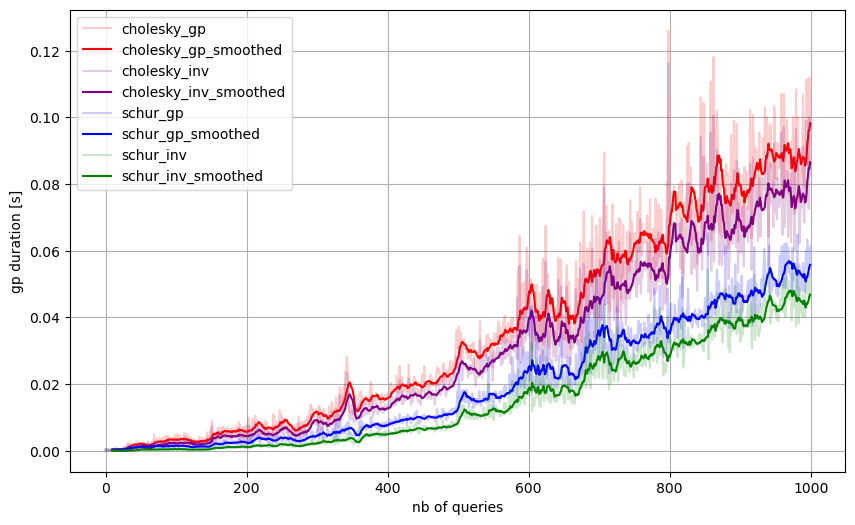

In [ ]:
x = np.arange(nb_it)

plt.figure(figsize=(10, 6))

plt.plot(x,gp2_duration, color='red', label='cholesky_gp', alpha=0.2)
plt.plot(x[smooth_int:],gp2_duration_s, color='red', label='cholesky_gp_smoothed')

plt.plot(x,inv2_duration, color='purple', label='cholesky_inv', alpha=0.2)
plt.plot(x[smooth_int:],inv2_duration_s, color='purple', label='cholesky_inv_smoothed')

plt.plot(x,gp1_duration, color='blue', label='schur_gp', alpha=0.2)
plt.plot(x[smooth_int:],gp1_duration_s, color='blue', label='schur_gp_smoothed')

plt.plot(x,inv1_duration, color='green', label='schur_inv', alpha=0.2)
plt.plot(x[smooth_int:],inv1_duration_s, color='green', label='schur_inv_smoothed')

plt.xlabel('nb of queries')
plt.ylabel('gp duration [s]')
plt.legend()
plt.grid()
plt.show()